# Topic evolution in NIPS dataset

## Corpus Preprocessing
1. Tokenization
2. Remove all punctuation and numbers
3. Replace all whitespace by single spaces
4. Remove stopwords and keep the words which frequency larger than 2

In [1]:
import csv
import pandas as pd
import os, re
import codecs
import os

In [2]:
DATA_DIR = "../nips-data"
MODEL_DIR = "../models"


In [3]:
papers = pd.read_csv(os.path.join(DATA_DIR, 'papers.csv'))

In [4]:
with open(os.path.join(MODEL_DIR, 'stopwords.txt')) as f:
    stopwords=[]
    for line in f:
        stopwords.append(line.strip())

### Time slice
To train the Dynamic Topic Model, we need to separate the data into different snapshots based on time. In my case, the time slice is one year, so I just sort the papers by year and store the number of papers from 1987 to 2016.

In [5]:
papers=papers.sort_values(by='year')
timelist=papers.groupby('year').size()
timeseq=timelist.values

In [7]:
%%time
from collections import defaultdict
pre_papers=[]
for i in range(len(papers)):
    paper=re.sub(r'(\-)','',papers['paper_text'][i].lower())
    paper=re.sub(r'[\s,\W,\d,_]\s*',' ',paper)
    paper=re.split(r'[\s]\s*',paper)
    paper=[word for word in paper if len(word)>=3 and word not in stopwords]
    frequency = defaultdict(int)
    for word in paper:
        frequency[word] += 1
    paper = [word for word in paper if frequency[word] > 2]
    pre_papers.append(paper)

CPU times: user 1min 25s, sys: 169 ms, total: 1min 26s
Wall time: 1min 25s


### Dictionary and Corpus
1. Construct a dictionary
2. Convert tokenized documents to vectors

Construct a dictionary and filter out words that occur too frequently or too rarely.
Produce the vectorized representation of the documents by computing bag-of-words.

In [8]:
from gensim import corpora
dictionary = corpora.Dictionary(pre_papers)

max_freq = 0.7
min_wordcount = 10
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)
corpus = [dictionary.doc2bow(paper) for paper in pre_papers]

### Save the Dictionary and Corpus
This step can be skipped.

In [9]:
dictionary.save(os.path.join(MODEL_DIR, 'topic_evolution', 'dictionary.dict'))
corpora.MmCorpus.serialize(os.path.join(MODEL_DIR, 'topic_evolution', 'corpus_mm.mm'), corpus)
corpora.BleiCorpus.serialize(os.path.join(MODEL_DIR, 'topic_evolution', 'corpus_lda.lda-c'), corpus)

In [10]:
from gensim.corpora import Dictionary, bleicorpus
bleicorpus.BleiCorpus.serialize(os.path.join(MODEL_DIR, 'topic_evolution', 'corpus_lda1.lda-c'), corpus)
corpus1 = bleicorpus.BleiCorpus(os.path.join(MODEL_DIR, 'topic_evolution', 'corpus_lda1.lda-c'))

## Train and use model
Use the DTM wrapper in gensim to train our model. In my case, the number of topics is 10.

In [12]:
from gensim.models.wrappers.dtmmodel import DtmModel

In [ ]:
%%time
dtm_home = os.environ.get('/Users/KK/CS/web/groupwork', "dtm-master")
dtm_path = os.path.join(dtm_home, 'bin', 'dtm') if dtm_home else None

model1 = DtmModel(dtm_path, corpus, timeseq, num_topics=10,
                 id2word= dictionary, initialize_lda=True)

Save the model that we trained so that you do not need to train it again.

In [14]:
model1.save(os.path.join(MODEL_DIR, 'topic_evolution', 'dtm_papers_10'))

### Visualising Dynamic Topic Models

the doc_topic file returned by our model can be used later.

In [13]:
model1 = DtmModel.load(os.path.join(MODEL_DIR, 'topic_evolution', 'dtm_papers_10'))

In [15]:
import pyLDAvis.gensim
doc_topic, topic_term, doc_lengths, term_frequency, vocab = model1.dtm_vis(time=0, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/home/illedran/.env/nipstimemachine/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


 Calculated the number of papers per topic per year and the proportion of each topic per year.
 
 The rank_table can be used to show the evolution of each topic.
 
 p_num: It is used to identify paper indexs for every year.
 
 p_sum: It denotes the proportion of each topic per year.

In [16]:
p_num=0
p_sum=[ 0 for i in range(10)]
rank_table=[]
for i in range(len(timeseq)):
    for j in range(p_num,p_num+timeseq[i]):
        index=doc_topic[j].tolist().index(max(doc_topic[j]))
        p_sum[index]+=1
    for k in range(10):
        p_sum[k]=p_sum[k]/timeseq[i]
    rank_table.append(p_sum)
    p_sum=[ 0 for i in range(10)]
    p_num+=timeseq[i]
    

In [17]:
import numpy as np
import pylab as pl

Show the evolution of all the topics and highlight topic that contains the paper ID that we search for.

In [18]:
def topic_evolution(paperid):
    pnum=papers['id'].tolist().index(paperid)
    tindex=doc_topic[pnum].tolist().index(max(doc_topic[pnum]))
    x=[i for i in range(1,31)]
    g_label = [i for i in range(1987,2017)]


    pl.figure(figsize=(20,7))
    for i in range(10):
        y=[ 0 for i in range(30)]
        for j in range(len(rank_table)):
            y[j]=rank_table[j][i]    
        if i==tindex:
            pl.plot(x, y, marker='*',label='topic'+str(i+1))
        else:
            pl.plot(x, y, label='topic'+str(i+1))

    pl.title("Topic Evolution")# give plot a title
    pl.xlabel("time")# make axis labels
    pl.ylabel("topic ranking")
 
    pl.xlim(0,33)# set axis limits
    pl.xticks(x, g_label, rotation=0) 
    pl.legend(loc='upper right') 
    pl.grid()
    pl.show()# show the plot on the screen

## Explore authors activities

Merge the files and reserve the information we need like paper IDs, year and author names.

In [19]:
authors = pd.read_csv(os.path.join(DATA_DIR, 'authors.csv'))

paper_author = pd.read_csv(os.path.join(DATA_DIR, 'paper_authors.csv'))

p_id2a_name=pd.merge(paper_author,authors,left_on='author_id',right_on='id',how='left')


s_papers=papers[['id','year']]
s_pid2aname=p_id2a_name[['paper_id','name']]
info_papers=pd.merge(s_papers,s_pid2aname,left_on='id',right_on='paper_id',how='right')

Construct a mapping from author names to paper IDs

In [20]:
author2doc = dict()
for j in range(len(info_papers)):
    if not author2doc.get(info_papers['name'][j]):
        author2doc[info_papers['name'][j]]=[]
    author2doc[info_papers['name'][j]].extend([info_papers['paper_id'][j]])

In [21]:
def authors_activities(name):
    author_topic = dict()
    for i in range(len(author2doc[name])):
        yrs=info_papers['year'][info_papers['paper_id'].tolist().index(author2doc[name][i])]
        if not author_topic.get(yrs):
            author_topic[yrs]=[0 for j in range(10)]
        pnum=papers['id'].tolist().index(author2doc[name][i])
        tindex=doc_topic[pnum].tolist().index(max(doc_topic[pnum]))
        author_topic[yrs][tindex]+=1
    pl.figure(figsize=(12,5))
    labels=['topic'+ str(i+1) for i in range(10)]
    x=np.arange(10)
    flag=1
    for i in author_topic:
        if flag:
            pl.bar(x,author_topic[i],label=i,tick_label=labels)
            lastone=author_topic[i]
            flag=0
        else:
            pl.bar(x,author_topic[i],bottom=lastone,label=i,tick_label=labels)
            lastone=[lastone[j]+author_topic[i][j] for j in range(10)]
    pl.title(name + "'s activities")# give plot a title
    pl.xlabel("topic name")# make axis labels
    pl.ylabel("the number of papers")
    pl.legend(loc='upper right') 
    pl.grid()
    pl.show()

In [22]:
def paper_information(paperid):
    topic_evolution(paperid)
    for i in range(len(info_papers)):
        if info_papers['id'][i]==paperid:
            authors_activities(info_papers['name'][i])
    

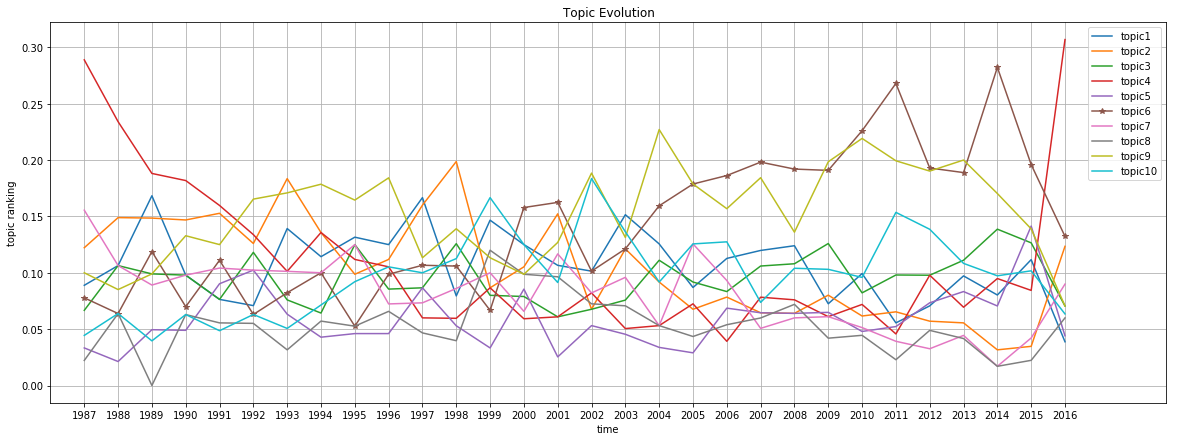

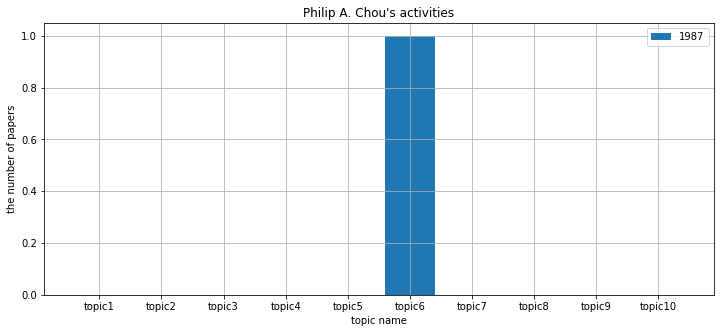

In [23]:
paper_information(2)

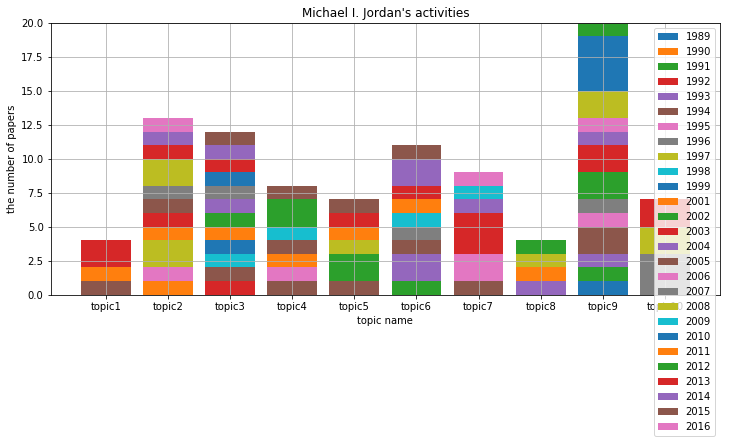

In [24]:
authors_activities('Michael I. Jordan')